In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
from matplotlib import cm
import anacal
import astropy.table as astTable
import glob

import numpy as np
import lsst.geom as geom
from astropy.io import ascii as astascii
import anacal
import astropy.table as astTable
import fitsio
import xlens
from matplotlib.ticker import MaxNLocator

In [3]:
if False:
    full = astTable.Table.read("/work/xiangchong.li/superonionGW/code/hsc_final/HSC_S23B_Shapes/notebook/3_data/fwhm_var_table.fits")
    full.sort(["index"])
    full2 = astTable.Table.read("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/tracts_fdfc_v1_trim6.fits")
    full2["fwhm"] = full["fwhm"]
    full2["var"] = full["var"]
    full2.write("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/tracts_fdfc_v1_trim6.fits", overwrite=True)
if False:
    full[[3381, 3613, 8948, 12563, 35020, 35439]]
    msk = np.ones(len(full)).astype(bool)
    msk[[3381, 3613, 8948, 12563, 35020, 35439]] = False
    full = full[msk]
    full.write("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/tracts_fdfc_v1_trim6.fits", overwrite=True)
if False:
    full = astTable.Table.read("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/tracts_fdfc_v1_trim6.fits")
    full["index"] = np.arange(len(full)).astype(int)
    full.write("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/tracts_fdfc_v1_trim6.fits", overwrite=True)

In [4]:
# Load catalog
full = astTable.Table.read("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/tracts_fdfc_v1_trim6.fits")

# All keys to extract
keys = ["e1_2", "r1_2", "e2_2", "r2_2", "e1_4", "r1_4", "e2_4", "r2_4",
        "e1_s", "r1_s", "e2_s", "r2_s", "e1_v", "r1_v", "e2_v", "r2_v"]

# Initialize containers
data = {k: [] for k in keys}
ids = []
# Loop through entries
for d in full:
    tid = d["tract"]
    patch_db = d["patch"]
    patch_x = patch_db // 100
    patch_y = patch_db % 100
    pid = patch_x + patch_y * 9

    fn = f"/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/database/s23b-anacal/tracts/{tid}/{pid}/leakage.fits"
    if not os.path.isfile(fn):
        continue
    if (d["var"] > 8e-3) | (d["var"] < 2e-3) | (np.sqrt(d["de1"]**2.0 + d["de2"]**2.0) > 8e-3)| (np.abs(d["dsize"]) > 0.02) :
        continue
    tab = fitsio.read(fn)
    for k in keys:
        data[k].append(np.asarray(tab[k]))
    ids.append(d["index"])

# Stack arrays
for k in keys:
    data[k] = np.vstack(data[k])

-0.0002861737598430951


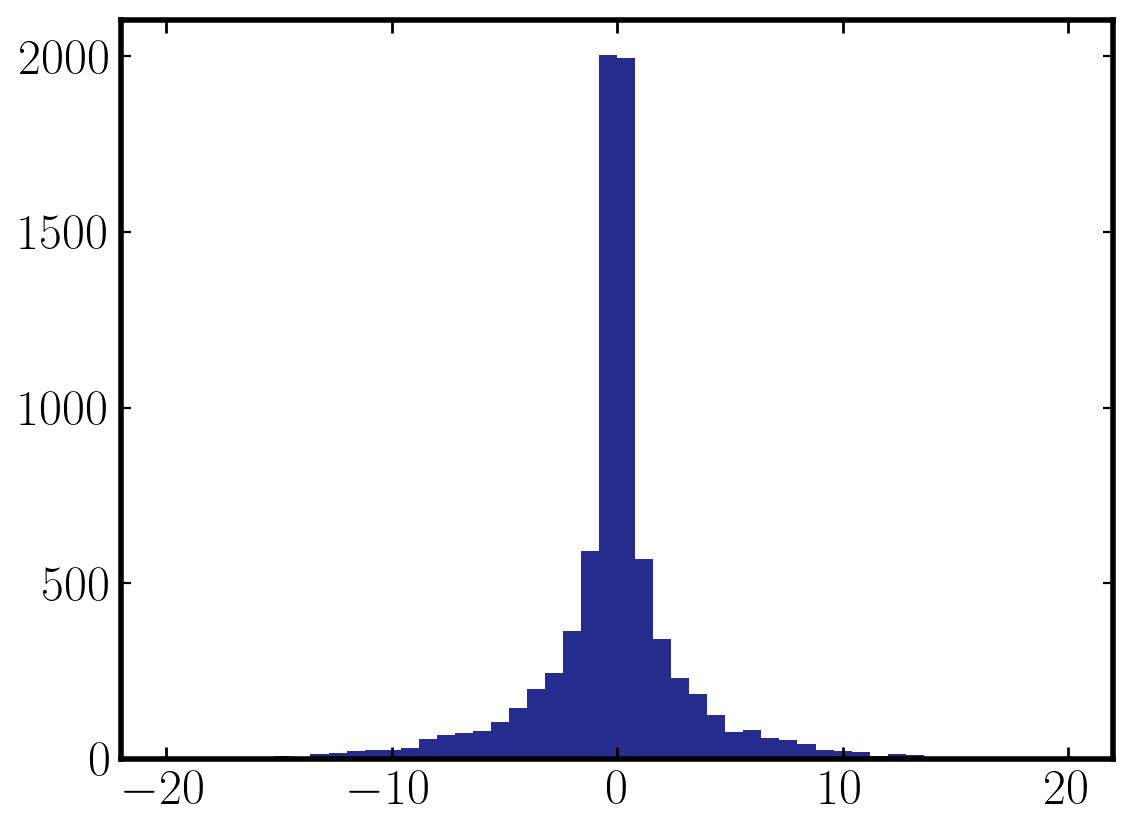

In [9]:
dt = data["e1_s"][:, 0]
dr = data["r1_s"][:, 0]
msk = dr!=0
dt = dt[msk]
dr = dr[msk]
ids = np.array(ids)
ids2 = ids[msk]
plt.hist(dt, bins=50, range=(-20, 20))
msk2 = (np.abs(dt) < 5)
print(np.sum(dt[msk2]) / np.sum(dr[msk2]))

-0.0005636777431066038
-0.043090014104123935


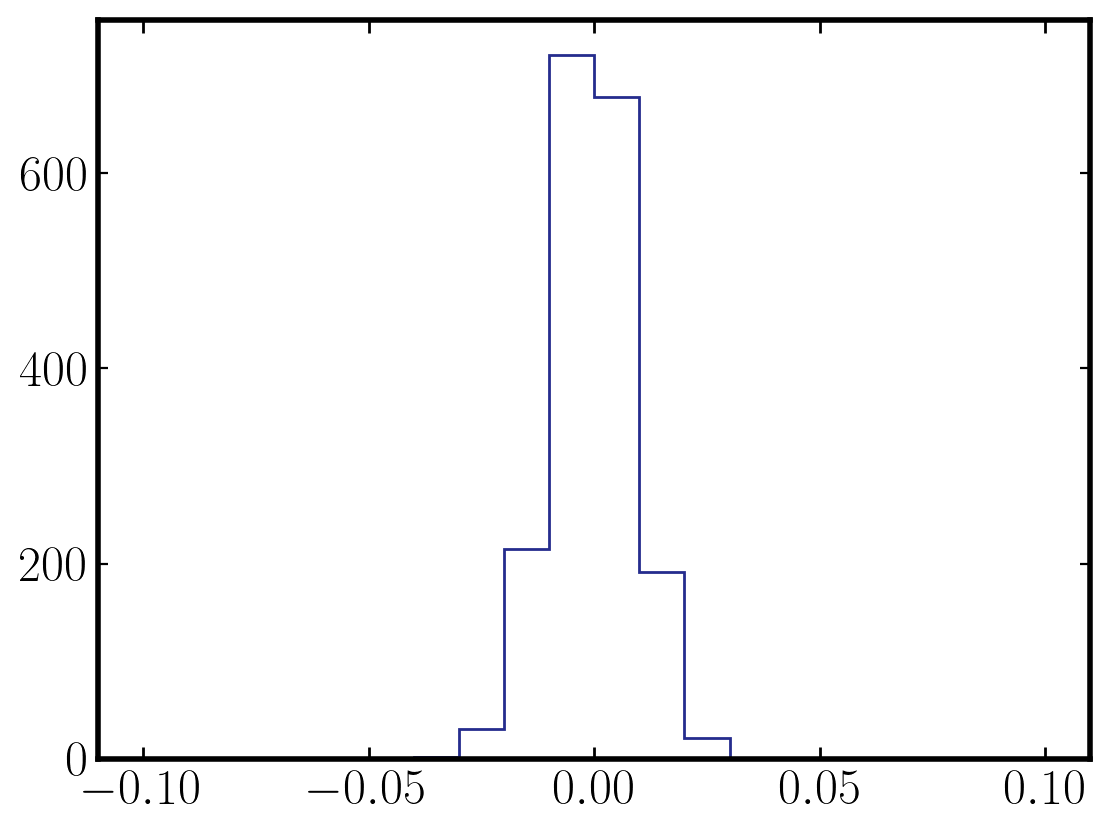

In [21]:
mm = (dr>400)
plt.hist(dt[mm] / dr[mm], bins=20, range=(-0.1, 0.1), histtype="step")
print(np.average(dt[mm] / dr[mm]))
print(np.min(dt[mm] / dr[mm]))

In [10]:
np.sum(msk2)

7036

In [27]:
mm = ((dt / dr) < -0.025) & (dr > 500)
full[ids2[mm]]

tract,patch,field,ra,dec,index,fwhm,var,de1,de2,dsize
int32,int32,bytes8,float64,float64,int64,float64,float64,float32,float32,float32
9953,603,autumn1,358.1388094203695,2.044718856378868,11077,0.49530347597464947,0.005273537416497277,-0.0012876329,0.005489368,-0.006078059
9375,305,spring3,220.92739124645715,-0.5571093576199004,16915,0.5094097858594283,0.003007054409910283,0.0014766718,-0.001053256,-0.005120198
15831,405,hectomap,244.64085228780147,42.583383554187506,26072,0.4704015818531226,0.004198693408479213,-0.00045469674,0.0008554344,-0.0039277296
9586,207,spring2,173.70671688711343,1.303779477524244,32294,0.5104083451992368,0.004088499214086446,-0.0008730079,-0.0010921309,-0.014065046
15818,704,hectomap,218.02624303598267,42.394218927422635,36480,0.5123592586676857,0.005468965925037806,0.0019521364,-0.006559406,-0.018768763


In [28]:
dt[mm]

array([-15.62392283, -17.46520783, -22.83616062, -18.32683633,
       -23.95433492])

In [31]:
inds = [9063, 22260, 22660, 23060, 23460, 23860, 24260, 24660, 32012, 25060, 25460, 25860, 26260, 26660, 27060, 27460, 27860, 28260, 28660, 29060, 29460, 29860]

In [37]:
for entry in full[0: 2]:
    tract_id = entry["tract"]
    patch_db = entry["patch"]
    patch_x = patch_db // 100
    patch_y = patch_db % 100
    patch_id = patch_x + patch_y * 9
    det_dir = f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal/{tract_id}/{patch_id}"
    det_fname = os.path.join(det_dir, "detect.fits")
    if os.path.isfile(det_fname):
        print(det_fname)

/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal/8279/63/detect.fits
/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal/8522/79/detect.fits


In [29]:
dr[mm]

array([598.26692644, 626.71788152, 773.29141135, 624.46141753,
       776.25978293])

In [30]:
dt[mm] / dr[mm]

array([-0.0261153 , -0.02786773, -0.02953112, -0.02934823, -0.03085866])

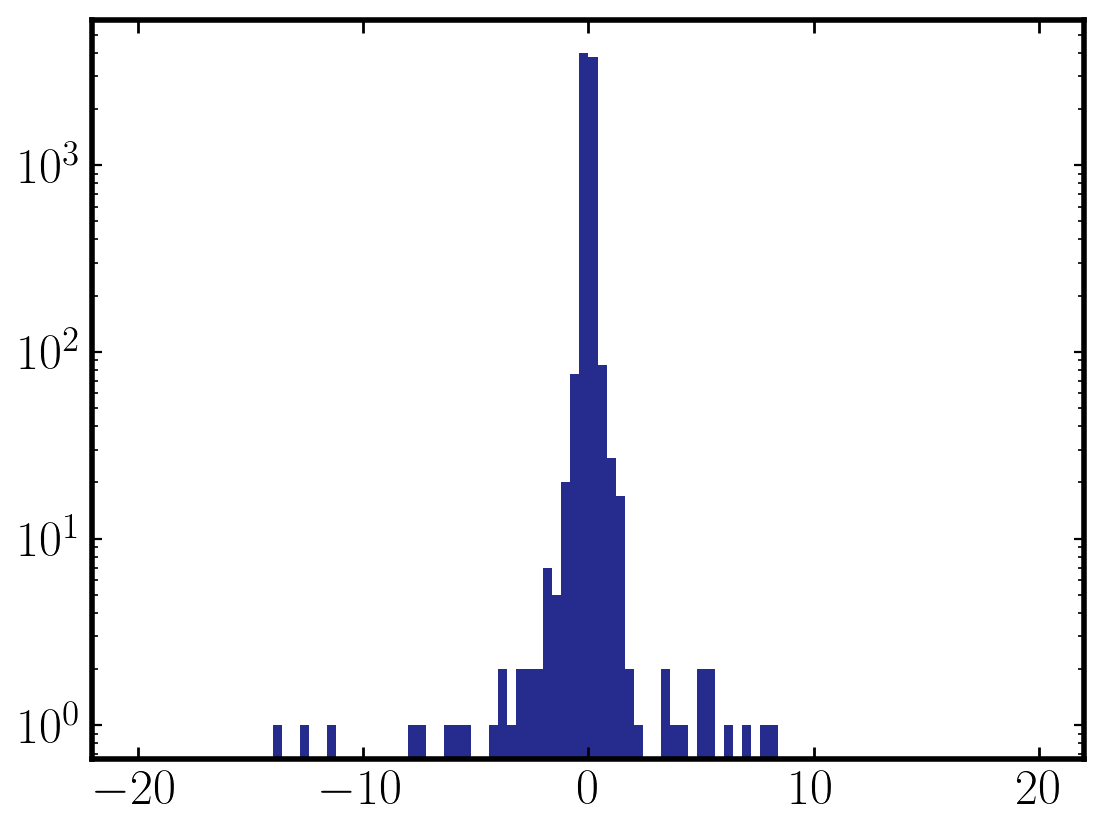

In [40]:
plt.hist(dt / dr, bins=100, range=(-20, 20))
plt.yscale("log")

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 3.000e+00,
        1.300e+01, 2.892e+03, 1.635e+03, 6.090e+02, 4.460e+02, 3.420e+02,
        3.640e+02, 3.040e+02, 2.430e+02, 1.850e+02, 1.880e+02, 2.010e+02,
        1.500e+02, 1.330e+02, 1.260e+02, 8.000e+01, 4.200e+01, 2.000e+01,
        9.000e+00, 6.000e+00, 7.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-1180.0337003 , -1094.79429494, -1009.55488959,  -924.31548424,
         -839.07607888,  -753.83667353,  -668.59726817,  -583.35786282,
         -498.11845747,  -412.87905211,  -327.63964676,  -242.4002414 ,
         -157.16083605,   -71.9214307 ,   

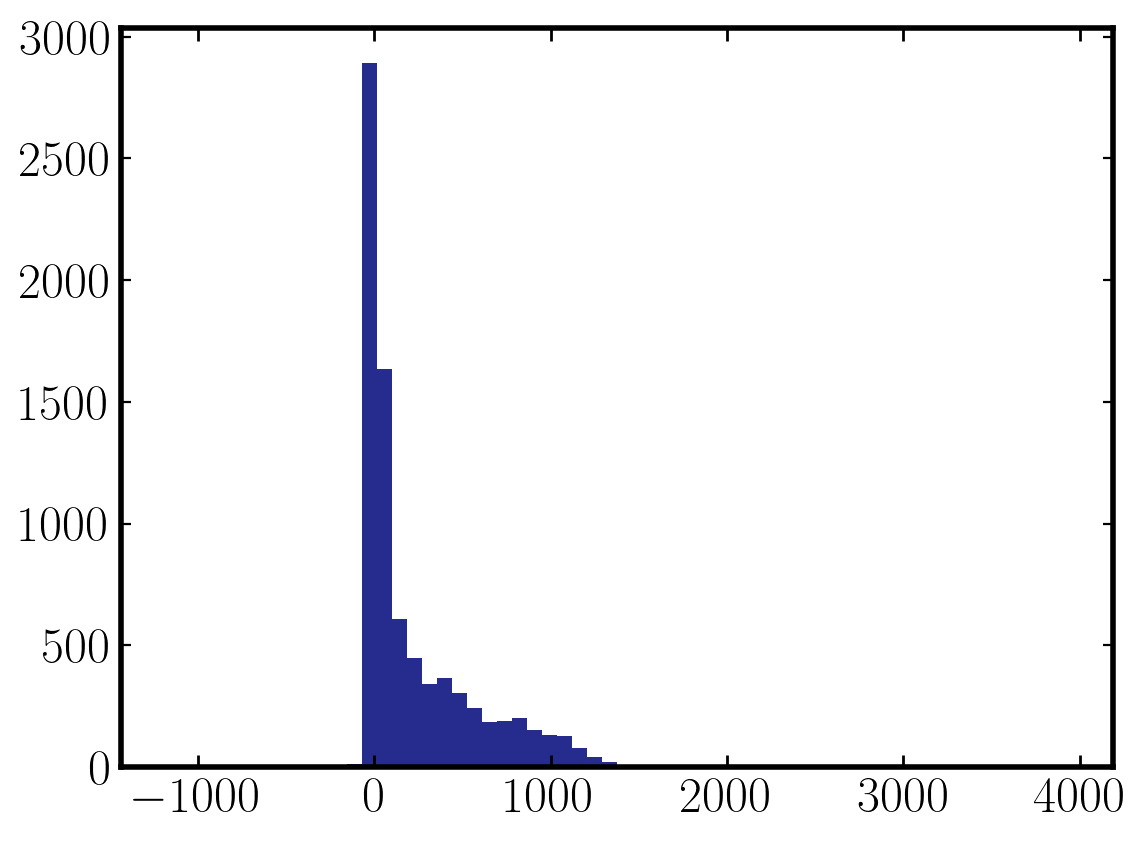

In [41]:
plt.hist(dr, bins=60)

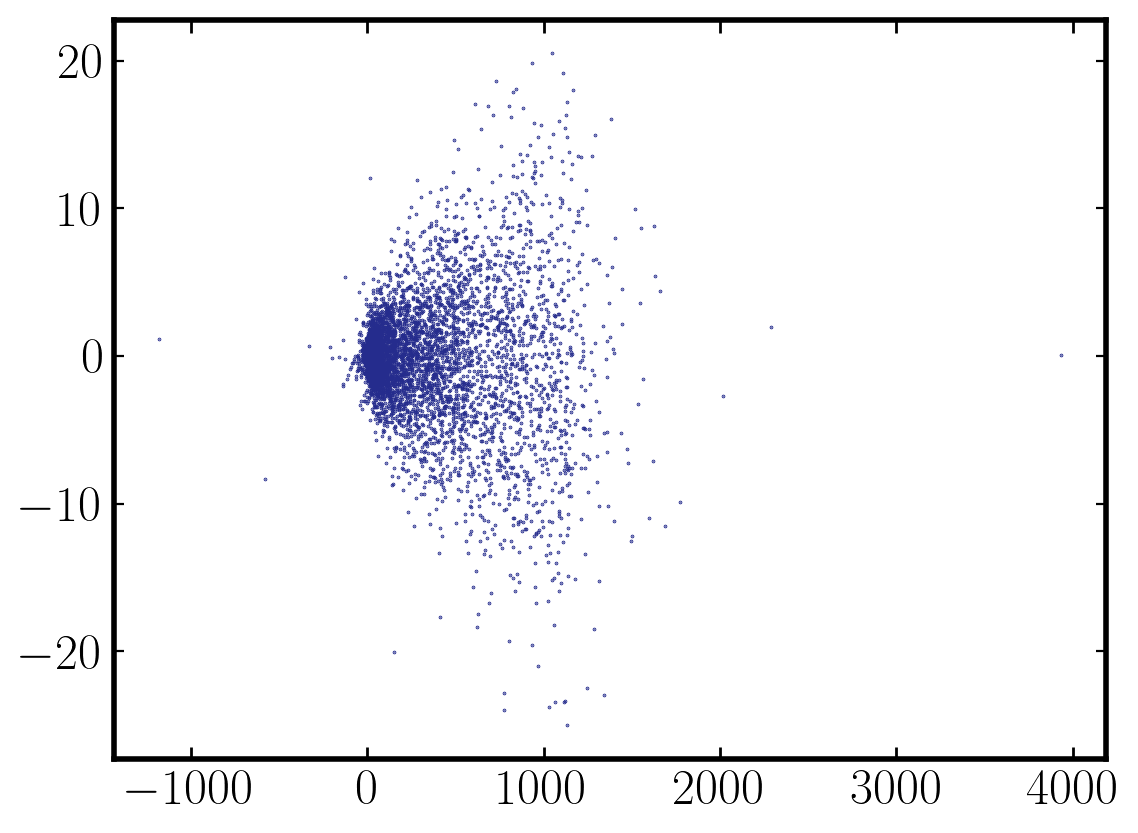

In [42]:
plt.scatter(dr, dt, s=0.1)

In [10]:
suffixes = ["2", "4", "s", "v"]
ave = {}
std = {}

n_bootstraps = 100
n = data["e1_2"].shape[0]
indices = np.random.randint(0, n, size=(n_bootstraps, n))

for suffix in suffixes:
    e1 = data[f"e1_{suffix}"]
    r1 = data[f"r1_{suffix}"]
    e2 = data[f"e2_{suffix}"]
    r2 = data[f"r2_{suffix}"]

    up1 = np.sum(e1[indices], axis=1)
    down1 = np.sum(r1[indices], axis=1)
    up2 = np.sum(e2[indices], axis=1)
    down2 = np.sum(r2[indices], axis=1)

    std[f"std1_{suffix}"] = np.std(up1 / down1, axis=0)
    std[f"std2_{suffix}"] = np.std(up2 / down2, axis=0)

    ave[f"ave1_{suffix}"] = np.sum(e1, axis=0) / np.sum(r1, axis=0)
    ave[f"ave2_{suffix}"] = np.sum(e2, axis=0) / np.sum(r2, axis=0) 

[0.03031399 0.00049901] 0.005315665293044209
[ 1.48337830e-02 -9.94784845e-05] 0.00571753138462161
[-0.05751087  0.00041712] 0.007405462721715058
[-6.22655159e-02 -3.01940131e-05] 0.0067994482100144134
[ 0.00512781 -0.0030912 ] 0.00046897264782382503
[ 0.00063675 -0.00033711] 0.00069899154606116
[ 0.08812107 -0.00040603] 0.05044019306810879
[ 0.06605828 -0.00022449] 0.031783916656875986


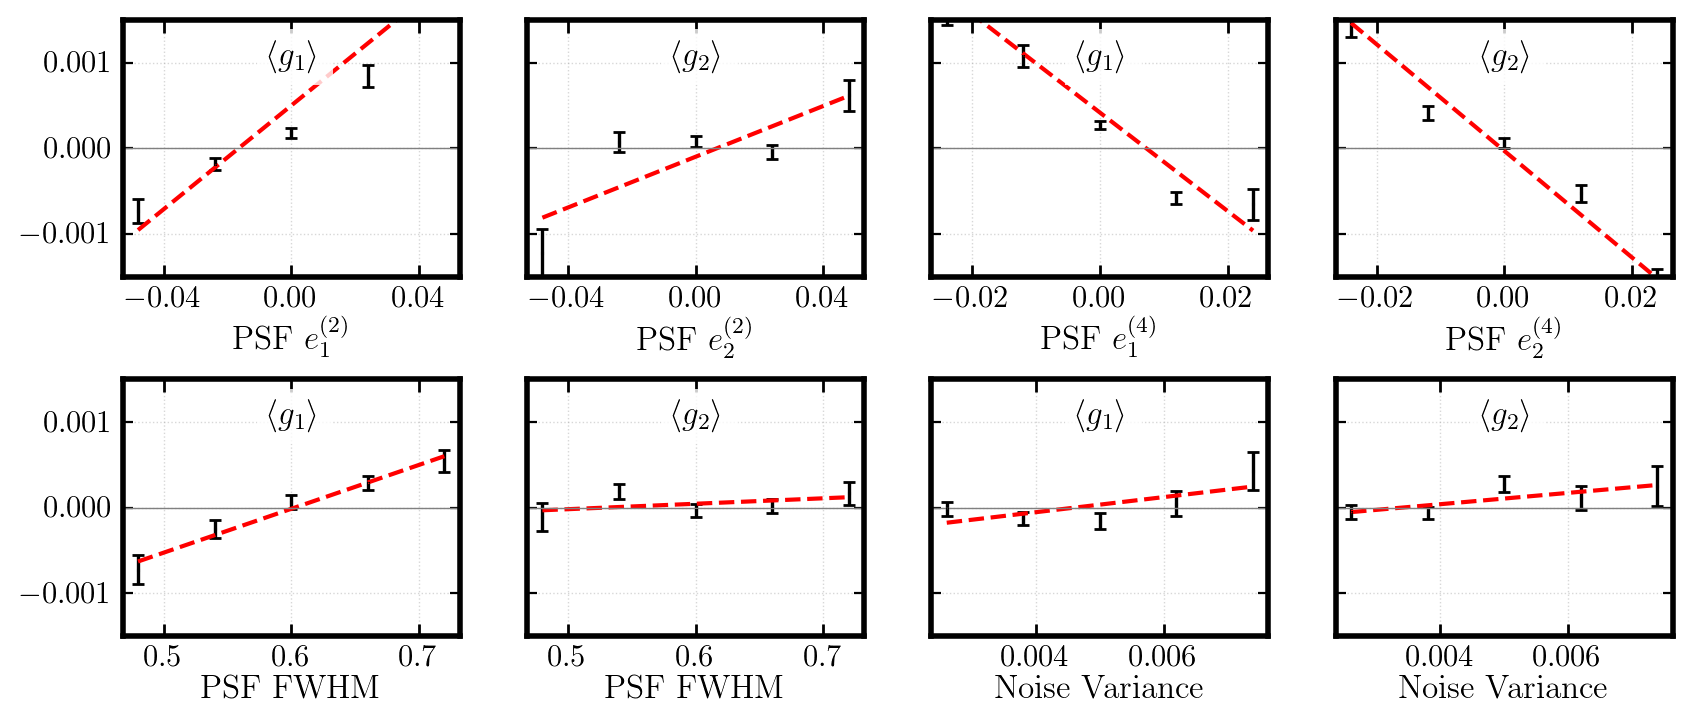

In [11]:
# Construct x_data
x_data = np.vstack([
    tab["e_psf_2"], tab["e_psf_2"],
    tab["e_psf_4"], tab["e_psf_4"],
    tab["size"],      tab["size"],
    tab["var"],       tab["var"]
])

# Construct y_data and y_errs from the ave/std dicts
pairs = [
    ("ave1_2", "std1_2"),
    ("ave2_2", "std2_2"),
    ("ave1_4", "std1_4"),
    ("ave2_4", "std2_4"),
    ("ave1_s", "std1_s"),
    ("ave2_s", "std2_s"),
    ("ave1_v", "std1_v"),
    ("ave2_v", "std2_v")
]

y_data = np.vstack([ave[k] for k, _ in pairs])
y_errs = np.vstack([std[k] for _, k in pairs])

# Prepare figure
fig, axes = plt.subplots(2, 4, figsize=(10, 4), sharey='row', gridspec_kw={'hspace': 0.4})
axes = axes.flatten()

# Titles and X-labels
titles = [r'$\langle g_1 \rangle$', r'$\langle g_2 \rangle$'] * 4
xlabels = [
    r'PSF $e_1^{(2)}$', r'PSF $e_2^{(2)}$',
    r'PSF $e_1^{(4)}$', r'PSF $e_2^{(4)}$',
    'PSF FWHM', 'PSF FWHM',
    'Noise Variance', 'Noise Variance'
]

# Loop over panels
for i, ax in enumerate(axes):
    x = x_data[i]
    y = y_data[i]
    yerr = y_errs[i]

    ax.errorbar(x, y, yerr=yerr, fmt='s', color='black', markersize=0.1, capsize=2, linewidth=1.2)

    # Linear fit with inverse variance weighting
    coeffs, cov = np.polyfit(x, y, deg=1, cov=True)
    print(coeffs, np.sqrt(cov[0, 0]))

    xfit = np.linspace(np.min(x), np.max(x), 100)
    ax.plot(xfit, np.polyval(coeffs, xfit), 'r--', linewidth=1.5)

    ax.axhline(0, color='gray', linewidth=0.5)
    ax.grid(True, linestyle=':', linewidth=0.5)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=3))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=3))

    ax.text(0.43, 0.92, titles[i], transform=ax.transAxes,
            fontsize=12, va='top', ha='left',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))

    ax.set_xlabel(xlabels[i], fontsize=12, labelpad=1)
    ax.set_ylim(-0.0015, 0.0015)
    ax.tick_params(labelsize=11)

plt.show()

In [ ]:
if False:
    a = fitsio.read("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/database/s23b-stars/stars.fits")
    e1p, e2p = xlens.catalog.basic.get_psf_ellip(a)
    e1s, e2s = xlens.catalog.basic.get_sdss_ellip(a)
    size_p = xlens.catalog.basic.get_psf_size(a, "trace")
    size_s = xlens.catalog.basic.get_sdss_size(a, "trace")
    msk = (~np.isnan(e1p)) & (~np.isnan(e1s)) & (~np.isnan(e2p)) & (~np.isnan(e2s)) & (np.abs(e1s) < 0.5) & (np.abs(e2s) < 0.5)
    e1p = e1p[msk]
    e1s = e1s[msk]
    e2p = e2p[msk]
    e2s = e2s[msk]
    size_p = size_p[msk]
    size_s = size_s[msk]
    
    data = astTable.Table()
    data["de1"] = e1p - e1s
    data["de2"] = e2p - e2s
    data["dsize"] = (size_p - size_s) / size_p
    data["tract"] = a["tract"][msk]
    data["patch"] = a["patch"][msk]
    out = []
    tract_list = np.unique(full["tract"])
    for tt in tract_list:
        sub = data[(data["tract"] == tt)]
        fsub = full[(full["tract"] == tt)]
        for ff in fsub:
            pp = ff["patch"]
            index = ff["index"]
            subsub = sub[sub["patch"] == pp]
            out.append((
                index,
                np.average(subsub["de1"]), np.average(subsub["de2"]), 
                np.average(subsub["dsize"])
            ))
            
    out = astTable.Table(rows=out, names=["index", "de1", "de2", "dsize"])
    full = astTable.Table.read("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/tracts_fdfc_v1_trim6.fits")
    full["de1"] = out["de1"]
    full["de2"] = out["de2"]
    full["dsize"] = out["dsize"]
    full.write("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/tracts_fdfc_v1_trim6.fits", overwrite=True)

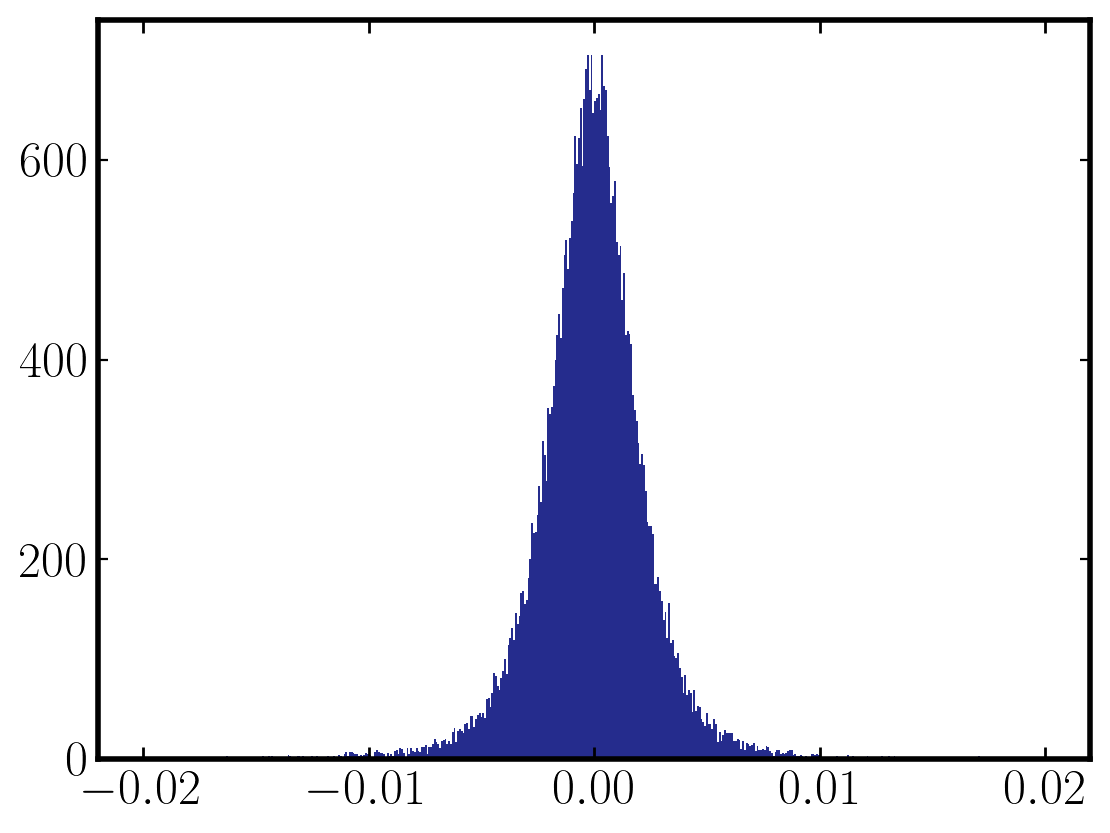

In [328]:
_=plt.hist(out["de1"], bins=500, range=(-0.02, 0.02))

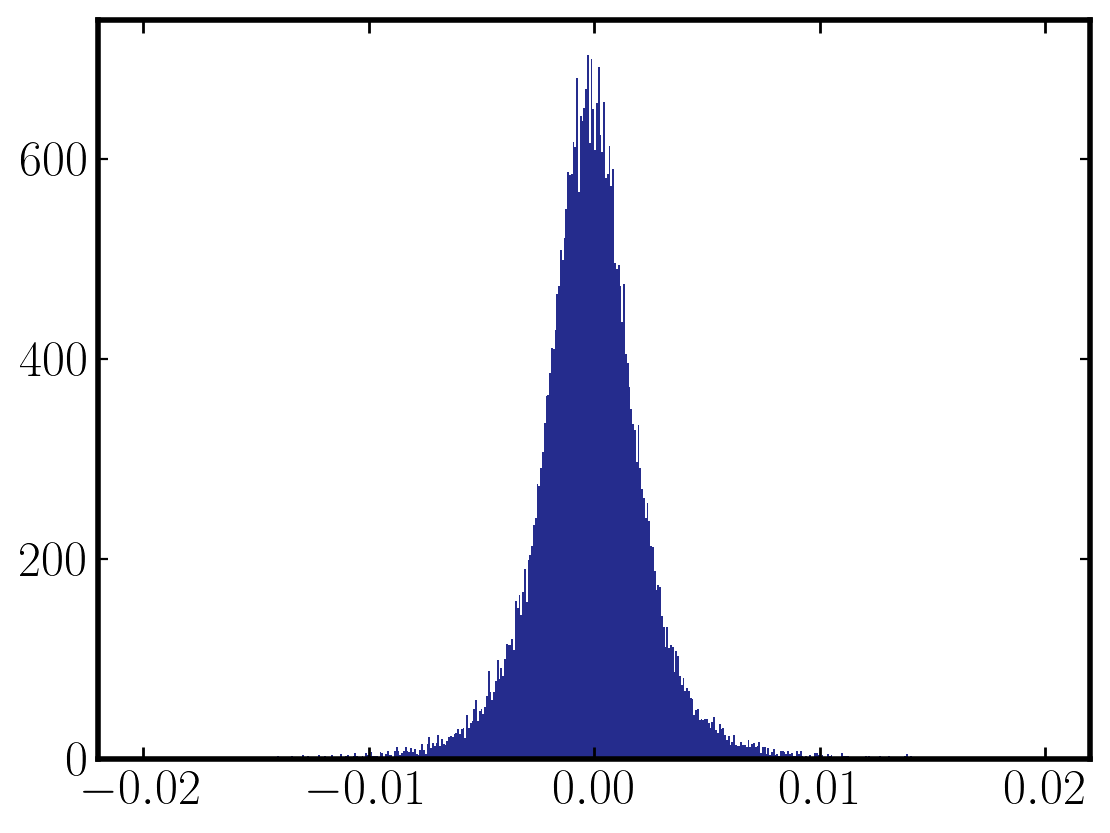

In [329]:
_=plt.hist(out["de2"], bins=500, range=(-0.02, 0.02))

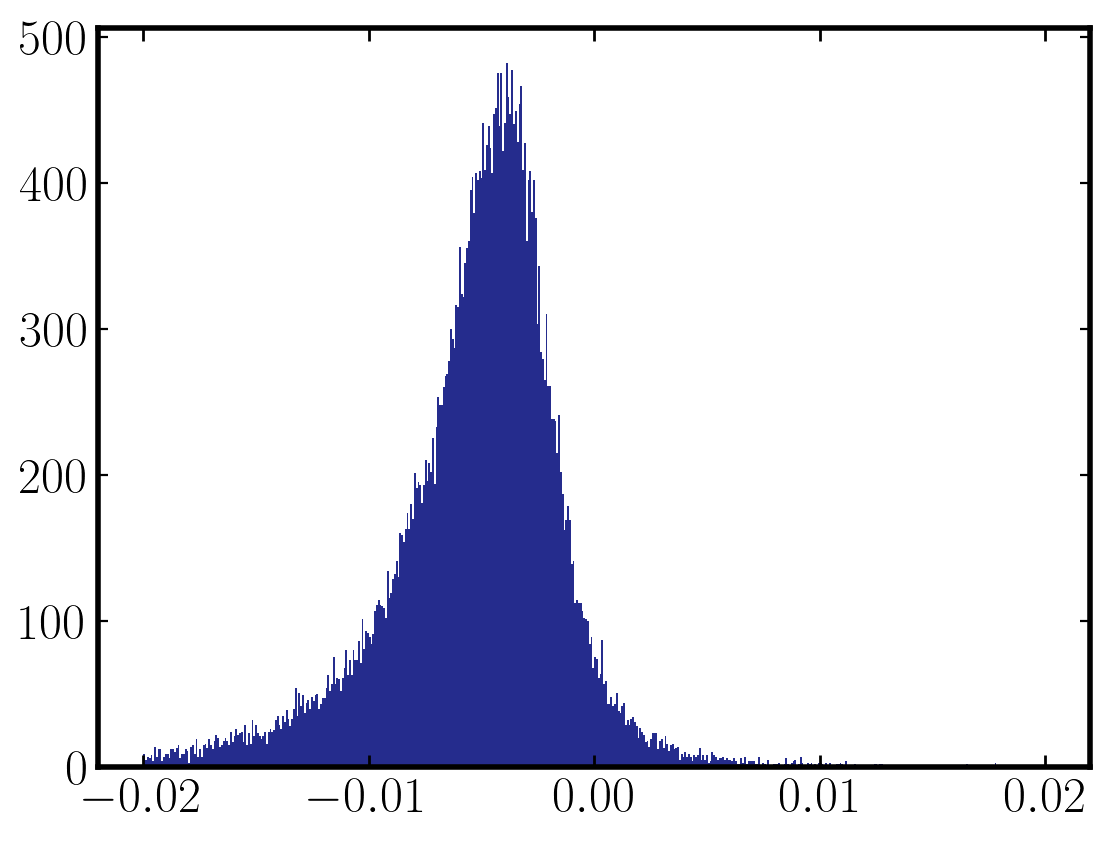

In [327]:
_=plt.hist(out["dsize"], bins=500, range=(-0.02, 0.02))

0.002234288998169889
0.017505922785042056


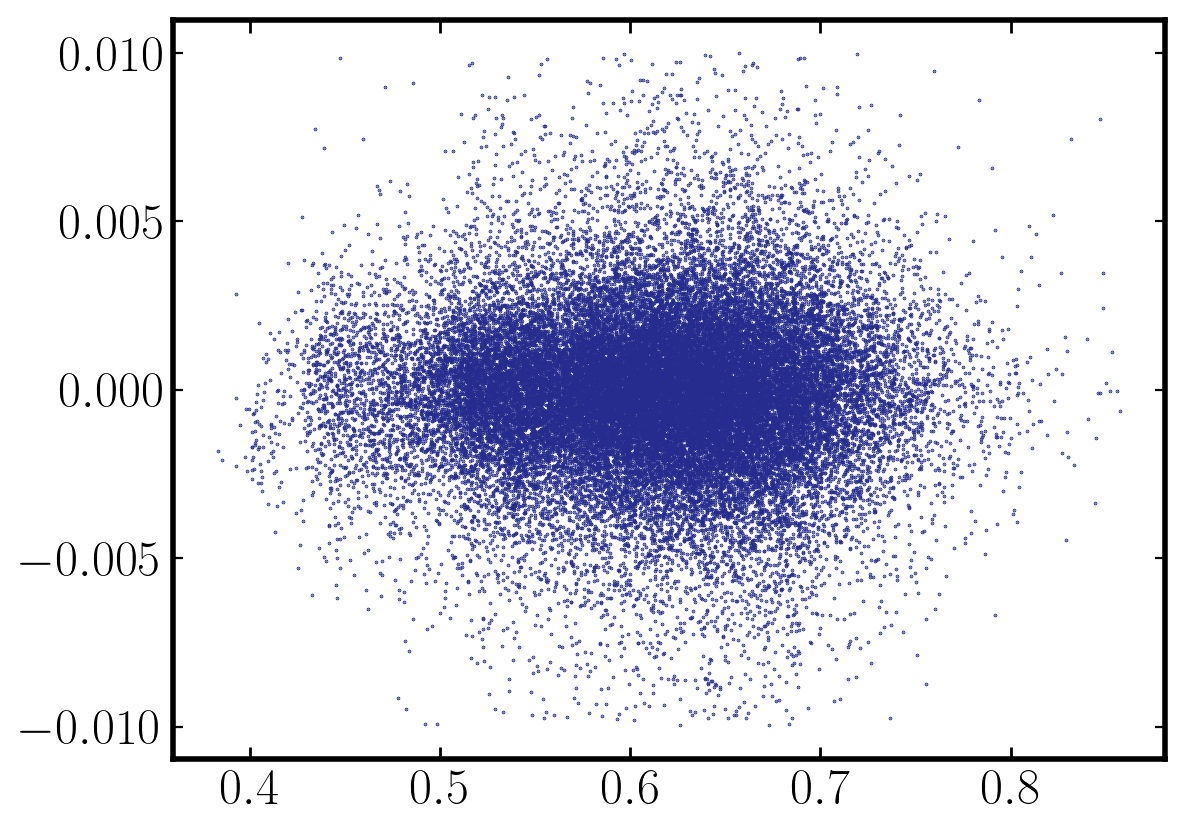

In [358]:
full = full[np.abs(full["de1"]) < 0.01]
plt.scatter(full["fwhm"], full["de1"], s=0.1)
print(np.corrcoef(full["fwhm"], full["de1"])[0, 1])
print(np.corrcoef(full["fwhm"], full["de2"])[0, 1])

0.019556666263955597
0.023205134972077174


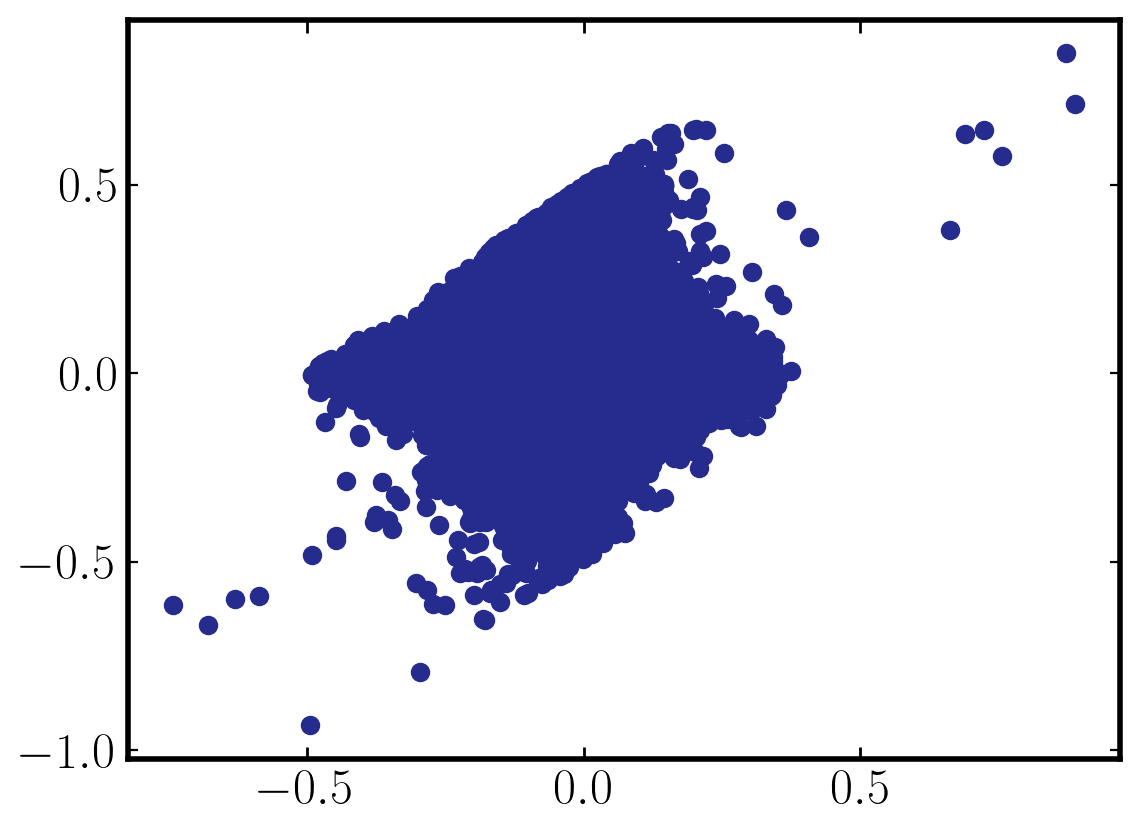

In [287]:
plt.scatter(e1p, e1p - e1s)
print(np.corrcoef(e1p, e1p - e1s)[0, 1])
print(np.corrcoef(e2p, e2p - e2s)[0, 1])

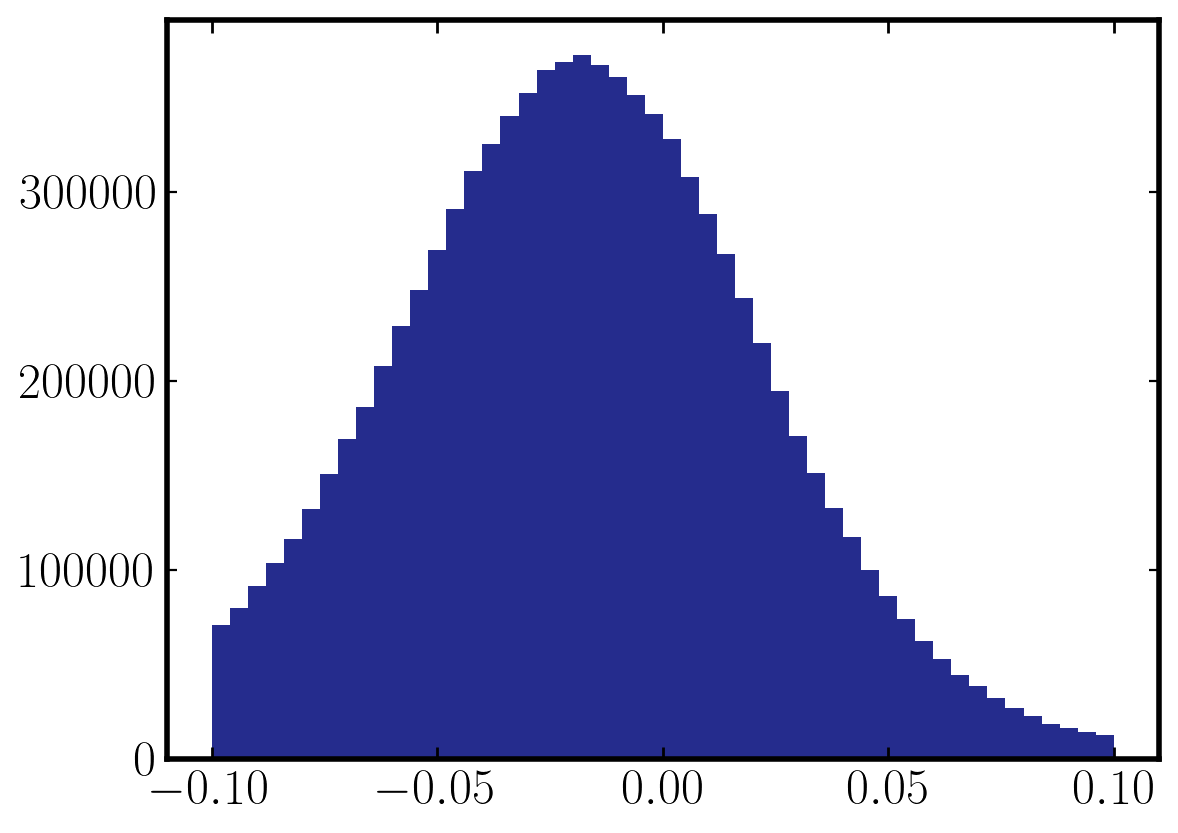

In [333]:
_=plt.hist(e1p, bins=50, range=(-0.1, 0.1))

(array([ 12281.,  14654.,  19814.,  29240.,  43071.,  53490.,  60469.,
         68551.,  76114.,  81717.,  95094., 111898., 140438., 174413.,
        205193., 225703., 240782., 257293., 268899., 284261., 304903.,
        340355., 382244., 404201., 420670., 428741., 431028., 414703.,
        407235., 405180., 395729., 373164., 347080., 317368., 280848.,
        254143., 224363., 194020., 164556., 142223., 122692., 102396.,
         84010.,  68979.,  56405.,  48933.,  38584.,  34574.,  30565.,
         25461.]),
 array([0.40000001, 0.40799999, 0.41600001, 0.42399999, 0.43200001,
        0.44      , 0.44800001, 0.456     , 0.46399999, 0.472     ,
        0.47999999, 0.48800001, 0.49599999, 0.50400001, 0.51200002,
        0.51999998, 0.528     , 0.53600001, 0.54400003, 0.55199999,
        0.56      , 0.56800002, 0.57599998, 0.58399999, 0.59200001,
        0.60000002, 0.60799998, 0.616     , 0.62400001, 0.63200003,
        0.63999999, 0.648     , 0.65600002, 0.66399997, 0.67199999,
        

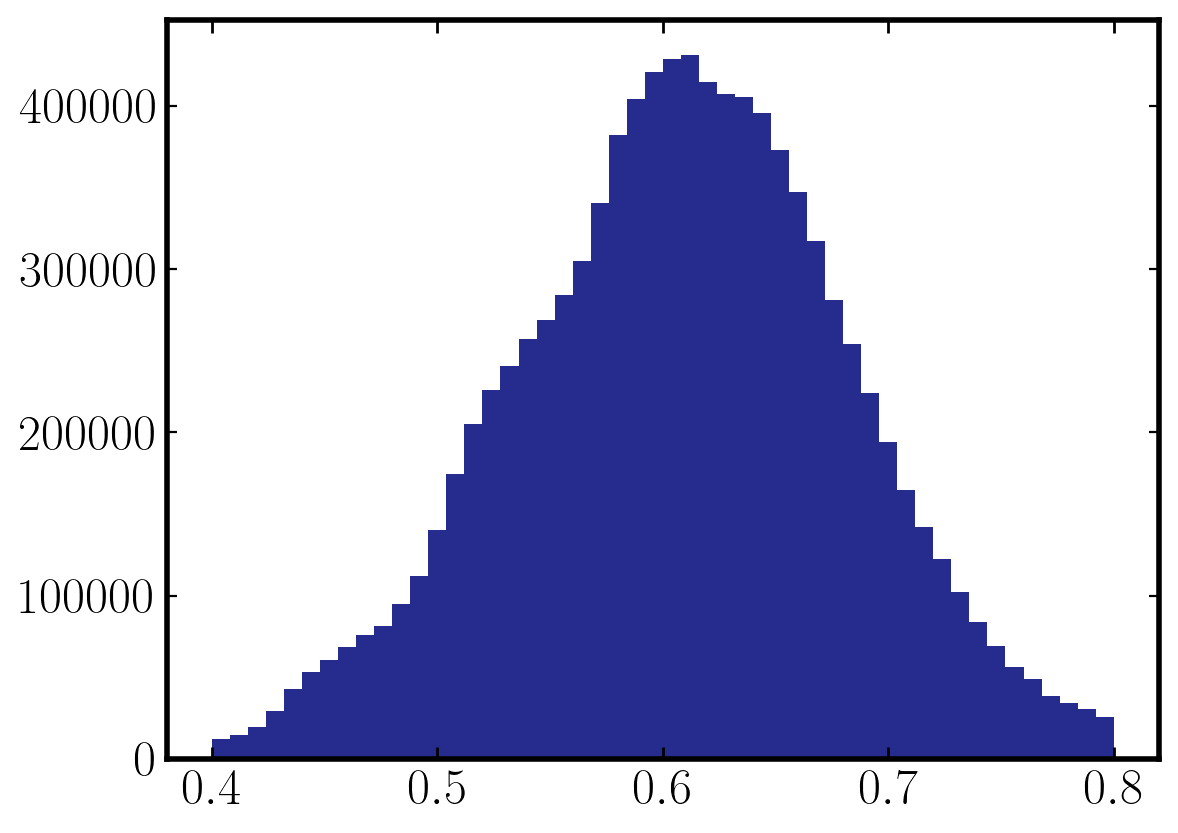

In [163]:
fwhm = xlens.catalog.basic.get_psf_size(a)
plt.hist(fwhm, bins=50, range=(0.4, 0.8))

In [372]:
a = fitsio.read("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/database/s23b-stars/stars.fits")
e1p, e2p = xlens.catalog.basic.get_psf_ellip(a)
e1s, e2s = xlens.catalog.basic.get_sdss_ellip(a)
size_p = xlens.catalog.basic.get_psf_size(a, "trace")
size_s = xlens.catalog.basic.get_sdss_size(a, "trace")
msk = (~np.isnan(e1p)) & (~np.isnan(e1s)) & (~np.isnan(e2p)) & (~np.isnan(e2s)) & (np.abs(e1s) < 0.5) & (np.abs(e2s) < 0.5)
fwhm = xlens.catalog.basic.get_psf_size(a)

In [373]:
e1s=e1s[msk]
fwhm=fwhm[msk]

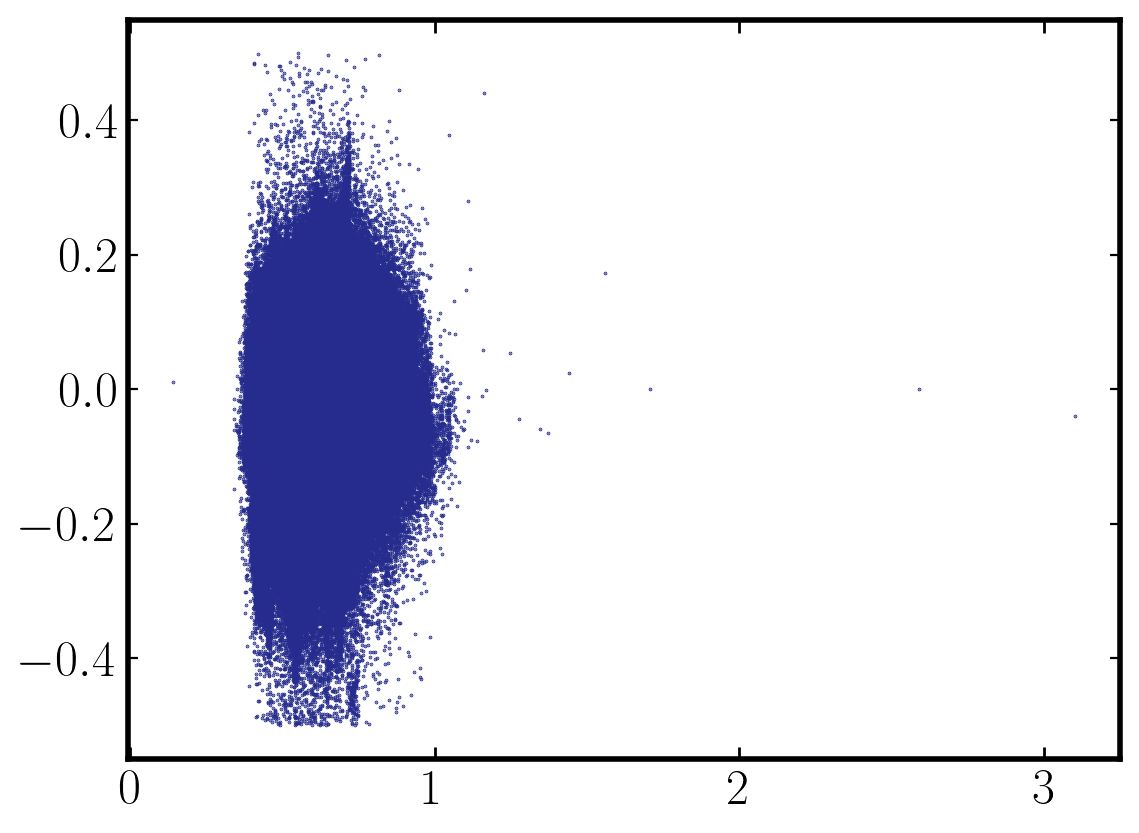

In [375]:
plt.scatter(fwhm, e1s, s=0.1)

In [148]:
nbins = 5
fieldnames = ["GAMA09H", "WIDE12H", "GAMA09H", "VVDS", "XMM", "HECTOMAP"]
import numpy.lib.recfunctions as rfn
size_val = []
g1_val = []
g2_val = []
e1_val = []
e2_val = []
w_val = []
for ff in fieldnames:
    dd = fitsio.read(f"/work/xiangchong.li/work/S19ACatalogs/catalog_obs_reGaus_calibrated/{ff}_calibrated.fits")
    g1, g2 = xlens.catalog.basic.get_shear_regauss(dd, mbias = -0.1)
    e1, e2 = xlens.catalog.basic.get_psf_ellip(dd)
    g1_val.append(g1)
    g2_val.append(g2)
    e1_val.append(e1)
    e2_val.append(e2)
    size_val.append(xlens.catalog.basic.get_psf_size(dd, "fwhm"))
    w_val.append(dd["i_hsmshaperegauss_derived_weight"])

In [149]:
size_val = rfn.stack_arrays(size_val, usemask=False)
g1_val = rfn.stack_arrays(g1_val, usemask=False)
g2_val = rfn.stack_arrays(g2_val, usemask=False)
e1_val = rfn.stack_arrays(e1_val, usemask=False)
e2_val = rfn.stack_arrays(e2_val, usemask=False)
w_val = rfn.stack_arrays(w_val, usemask=False)

In [150]:
bins = np.linspace(0.45, 0.75, nbins + 1)
bc = 0.5 * (bins[:-1] + bins[1:])
a1 = np.histogram(size_val, weights=g1_val * w_val, bins=bins)[0]
a2 = np.histogram(size_val, weights=g2_val * w_val, bins=bins)[0]
d = np.histogram(size_val, weights=w_val, bins=bins)[0]

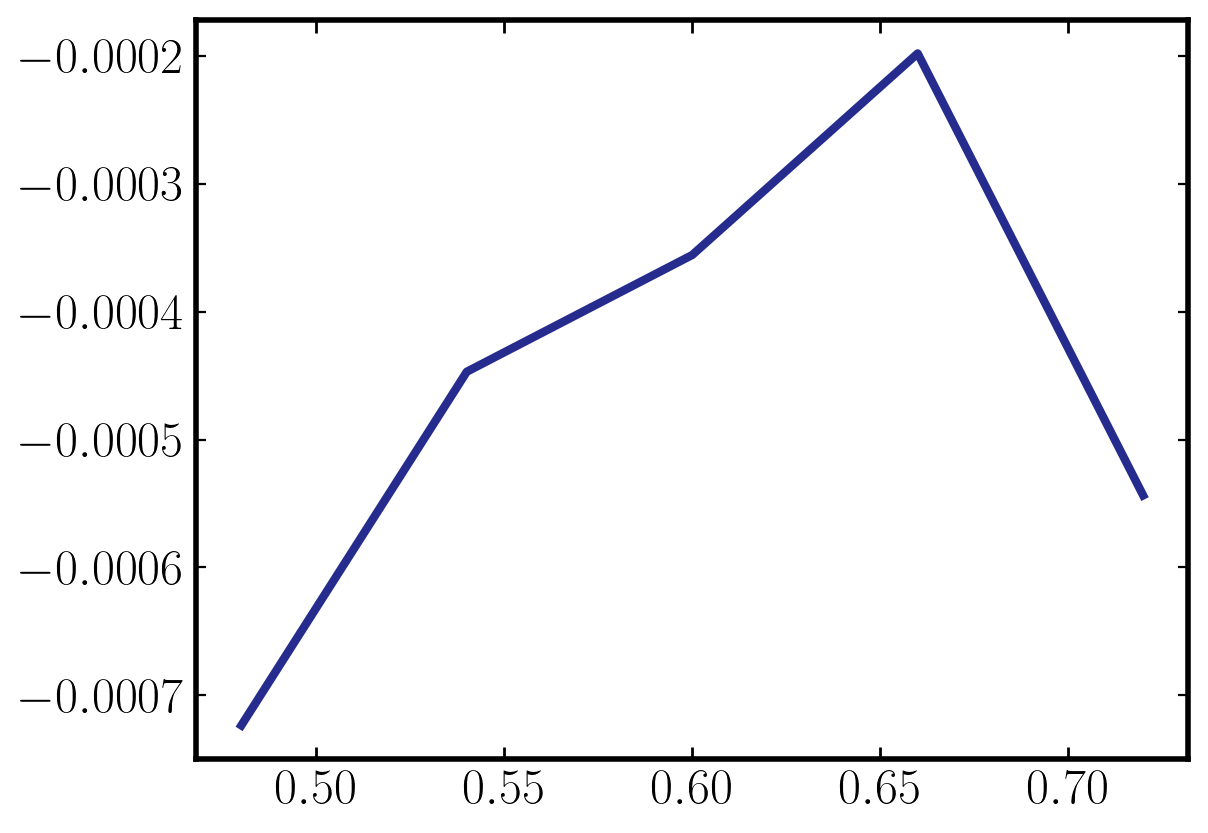

In [151]:
plt.plot(bc, a1 / d)

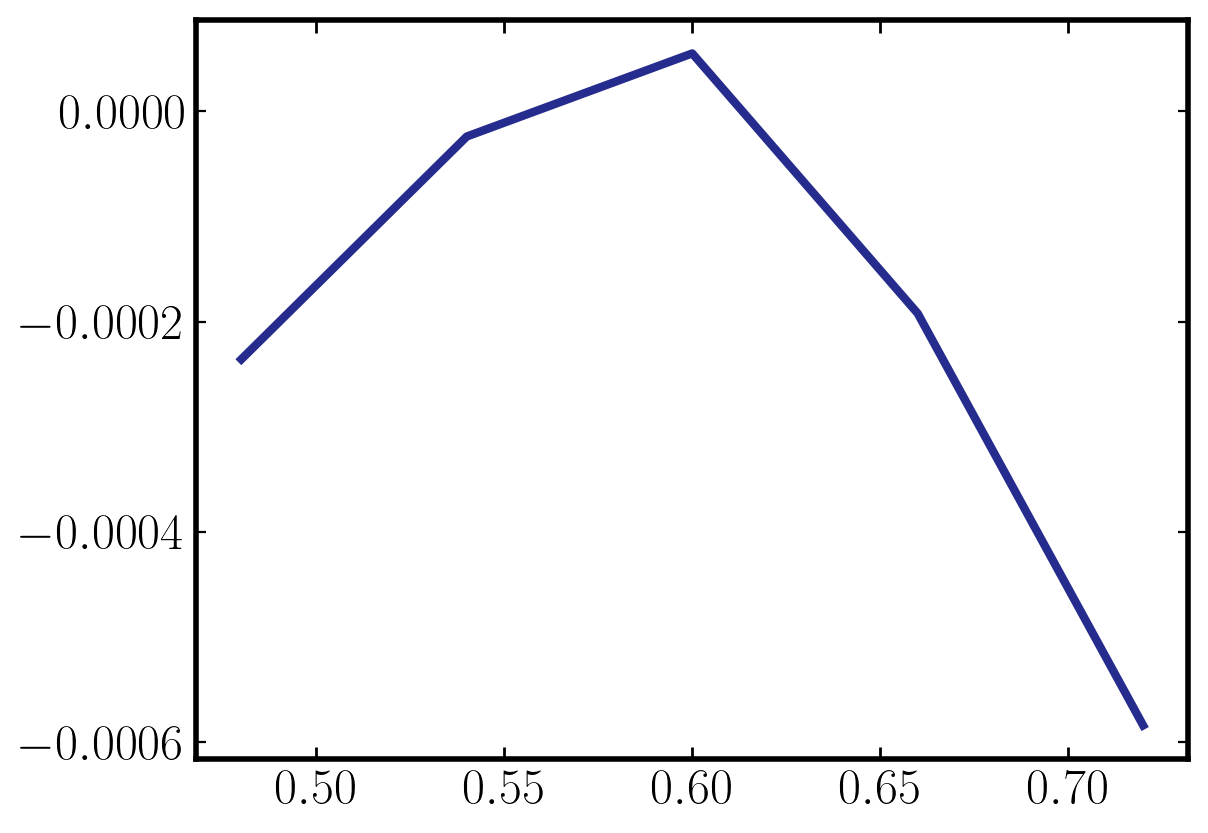

In [152]:
plt.plot(bc, a2 / d)

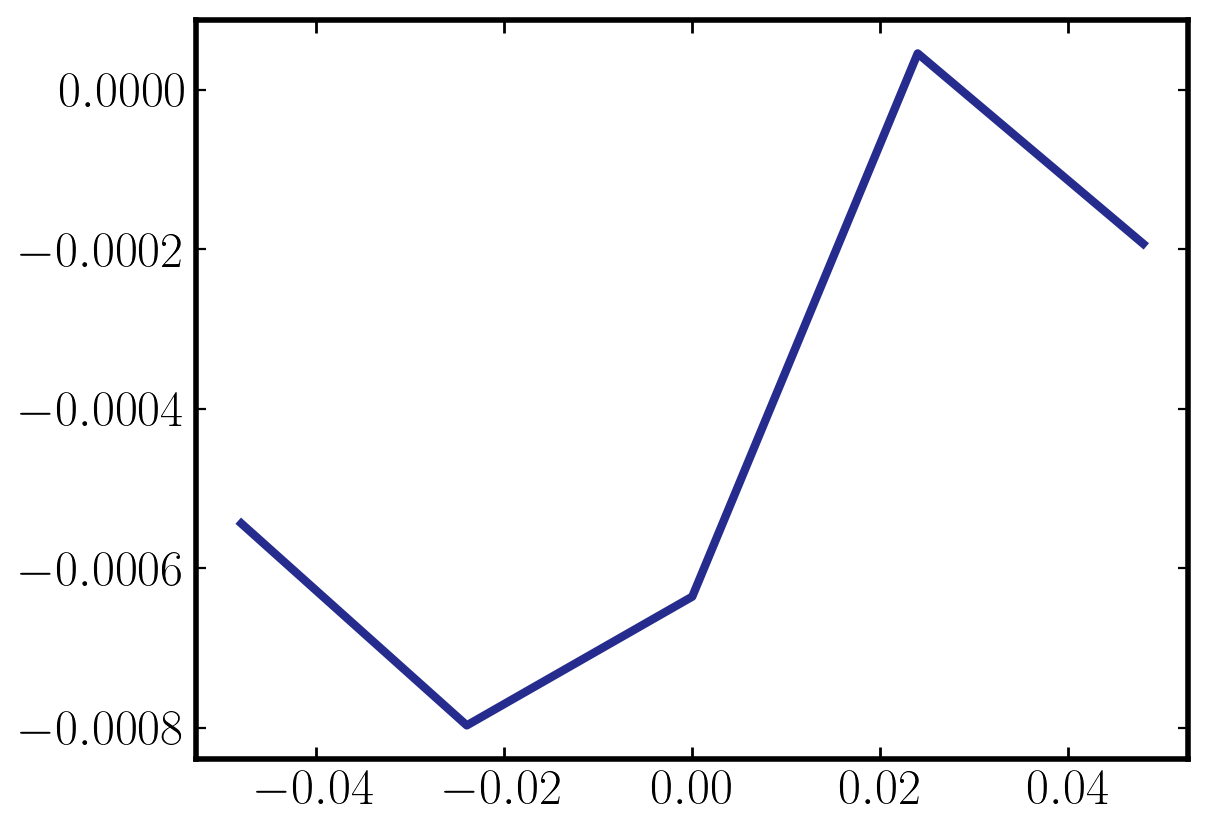

In [153]:
bins = np.linspace(-0.06, 0.06, nbins + 1)
bc = 0.5 * (bins[:-1] + bins[1:])
b1 = np.histogram(e1_val, weights=g1_val * w_val, bins=bins)[0]
d1 = np.histogram(e1_val, weights=w_val, bins=bins)[0]
b2 = np.histogram(e2_val, weights=g2_val * w_val, bins=bins)[0]
d2 = np.histogram(e2_val, weights=w_val, bins=bins)[0]
plt.plot(bc, b1 / d1)

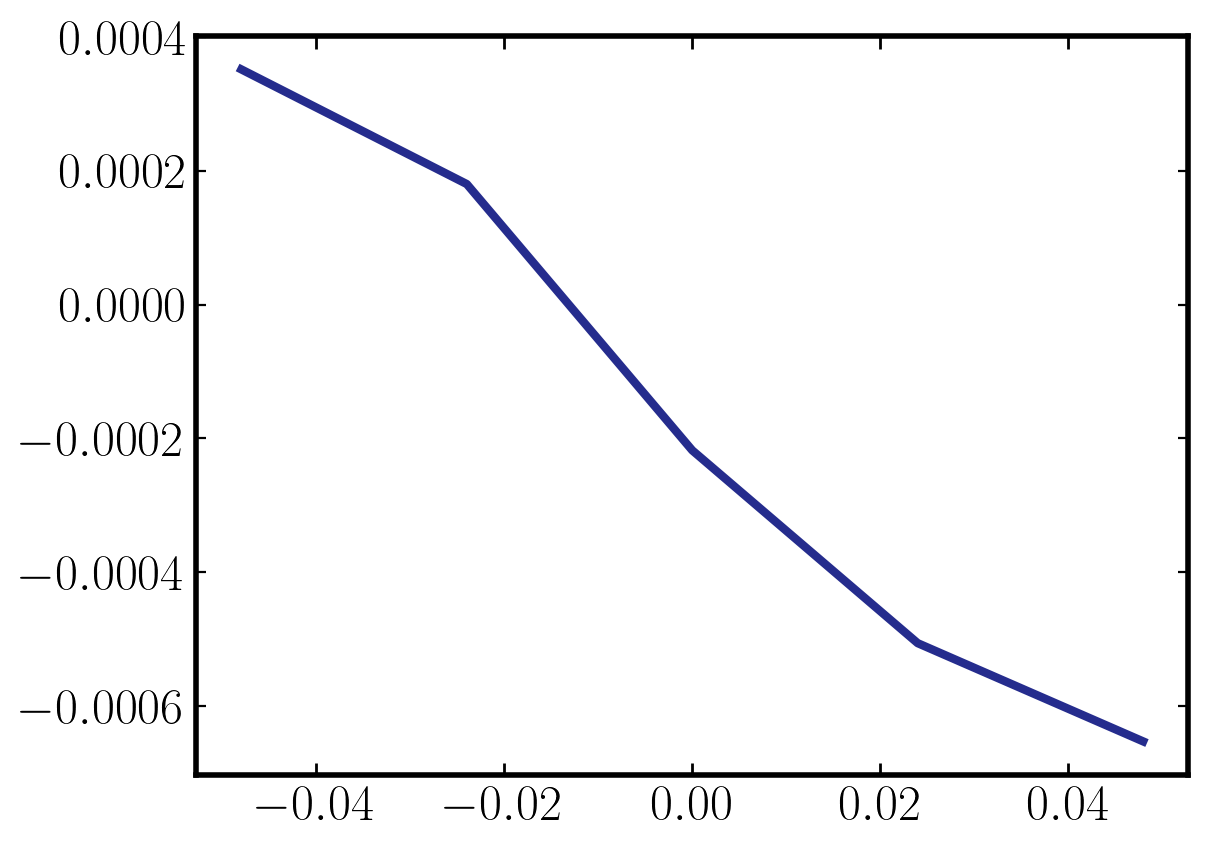

In [154]:
plt.plot(bc, b2 / d2)

In [110]:
tlist = np.unique(full["tract"])
dall = []
for tt in tlist:
    fname = f"/work/xiangchong.li/superonionGW/code/hsc_final/HSC_S23B_Shapes/sql/database/s23b-galaxy/tracts/{tt}.fits"
    if os.path.isfile(fname):
        dall.append(fitsio.read(fname))
dall = rfn.stack_arrays(dall, usemask=False)

-0.0034552698


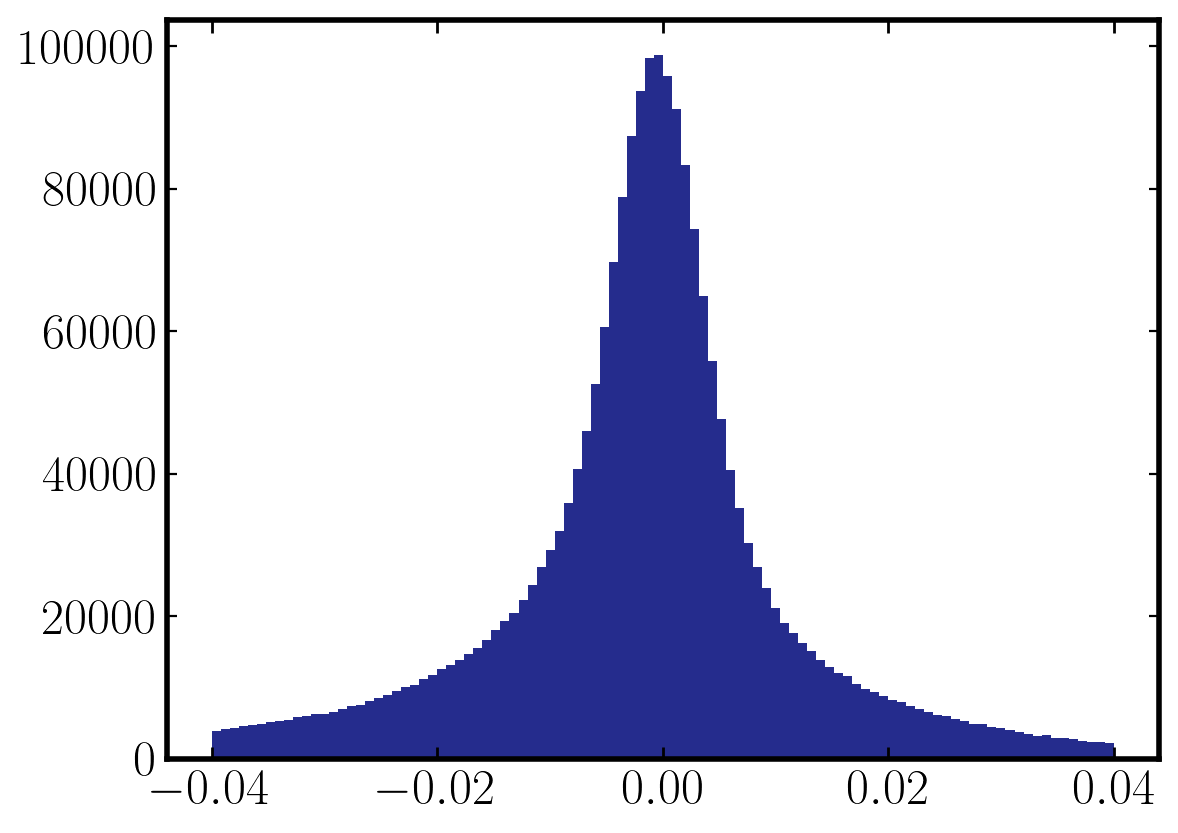

In [128]:
ss = (dall["i_hsmsourcemoments_shape11"] * dall["i_hsmsourcemoments_shape22"] - dall["i_hsmsourcemoments_shape12"] ** 2.0) ** 0.25
sp = (dall["i_hsmpsfmoments_shape11"] * dall["i_hsmpsfmoments_shape22"] - dall["i_hsmpsfmoments_shape12"] ** 2.0) ** 0.25
_=plt.hist((sp - ss) / ss, bins=100, range=(-0.04, 0.04))
print(np.nanmean((sp - ss) / ss))

-0.0037314137


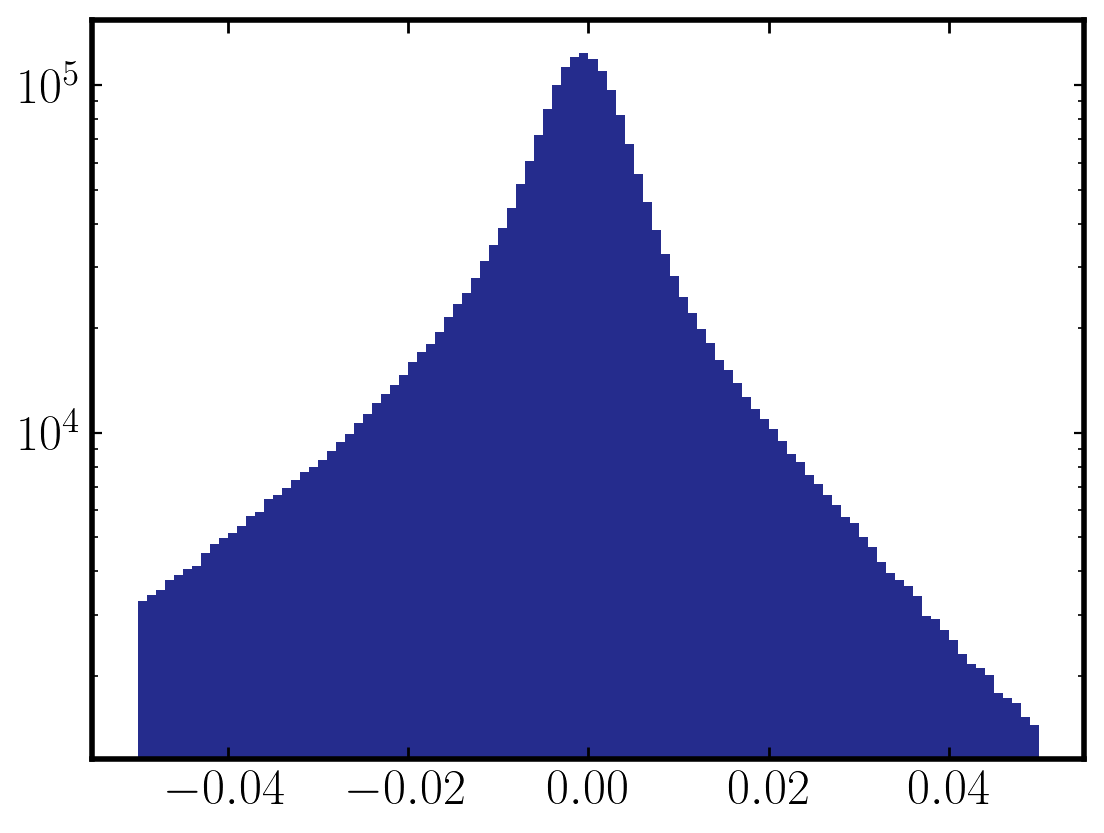

In [132]:
ss = (dall["i_hsmsourcemoments_shape11"] + dall["i_hsmsourcemoments_shape22"] ) ** 0.5
sp = (dall["i_hsmpsfmoments_shape11"] + dall["i_hsmpsfmoments_shape22"]) ** 0.5
_=plt.hist((sp - ss) / ss, bins=100, range=(-0.05, 0.05))
print(np.nanmean((sp - ss) / ss))
plt.yscale("log")

-0.00018238285


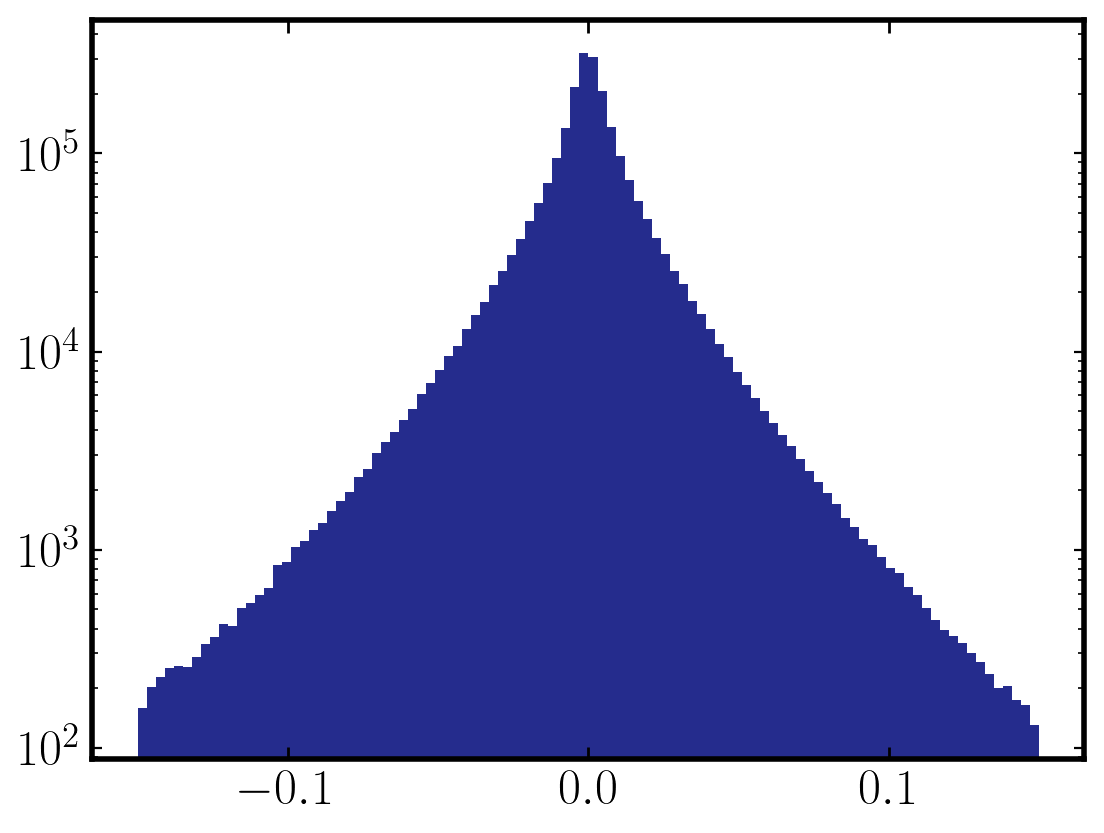

In [141]:
es1 = (dall["i_hsmsourcemoments_shape11"] - dall["i_hsmsourcemoments_shape22"] ) / (dall["i_hsmsourcemoments_shape11"] + dall["i_hsmsourcemoments_shape22"] )
ep1 = (dall["i_hsmpsfmoments_shape11"] - dall["i_hsmpsfmoments_shape22"]) / (dall["i_hsmpsfmoments_shape11"] + dall["i_hsmpsfmoments_shape22"])
_=plt.hist(ep1 - es1, bins=100, range=(-0.15, 0.15))
print(np.nanmean(ep1-es1))
plt.yscale("log")

In [137]:
msk = np.abs(ep1-es1) < 0.15
np.corrcoef(ep1[msk], ep1[msk]-es1[msk])

array([[1.        , 0.01261134],
       [0.01261134, 1.        ]])

In [144]:
1 | 4

5

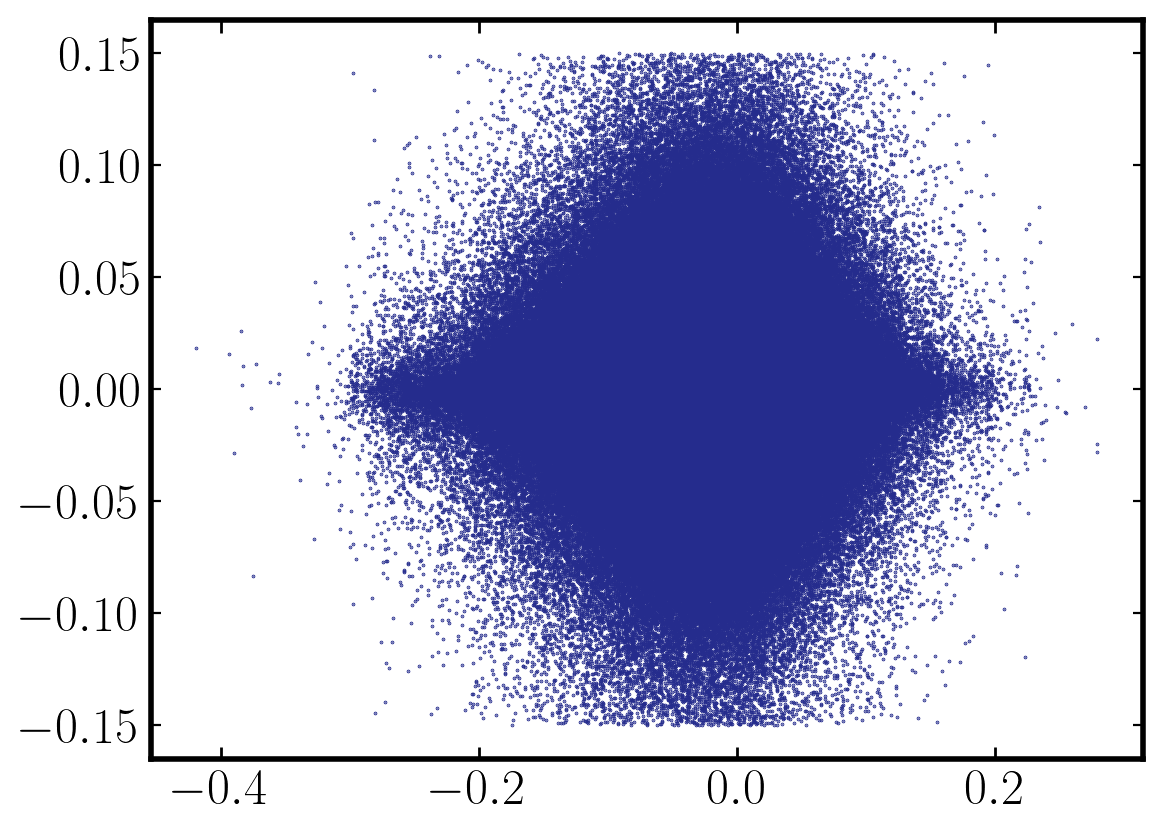

In [139]:
plt.scatter(ep1[msk], ep1[msk]-es1[msk], s=0.1)

In [ ]:
wget -r -np -nH --cut-dirs=7 --reject 'index.html*' https://hscdata.mtk.nao.ac.jp/hsc_ssp/dr4/s23b/data/s23b_wide/unified/deepCoadd_nImage/9824/37/i/